We need to understand in detail the numbers we are using to evaluate the performance of YOLACT. These are computed inside eval.py using the APDataObject class. 

Here is the code for APDataObject, copied from eval.py:

In [58]:
import pickle
import numpy as np
import matplotlib.pyplot as plt

class APDataObject:
    """
    Stores all the information necessary to calculate the AP for one IoU and one class.
    Note: I type annotated this because why not.
    
    WJP: I added the classname arg to the init. Could be handy! 
    """

    def __init__(self, cname = None):
        self.classname = cname
        self.data_points = []
        self.num_gt_positives = 0

    def push(self, score:float, is_true:bool):
        self.data_points.append((score, is_true))
    
    def add_gt_positives(self, num_positives:int):
        """ Call this once per image. """
        self.num_gt_positives += num_positives

    def is_empty(self) -> bool:
        return len(self.data_points) == 0 and self.num_gt_positives == 0

    def get_ap(self) -> float:
        """ Warning: result not cached. """

        if self.num_gt_positives == 0:
            return 0

        # Sort descending by score
        self.data_points.sort(key=lambda x: -x[0])

        precisions = []
        recalls    = []
        num_true  = 0
        num_false = 0

        # Compute the precision-recall curve. The x axis is recalls and the y axis precisions.
        for datum in self.data_points:
            # datum[1] is whether the detection a true or false positive
            if datum[1]: num_true += 1
            else: num_false += 1
            
            precision = num_true / (num_true + num_false)
            recall    = num_true / self.num_gt_positives

            precisions.append(precision)
            recalls.append(recall)

        # Smooth the curve by computing [max(precisions[i:]) for i in range(len(precisions))]
        # Basically, remove any temporary dips from the curve.
        # At least that's what I think, idk. COCOEval did it so I do too.
        for i in range(len(precisions)-1, 0, -1):
            if precisions[i] > precisions[i-1]:
                precisions[i-1] = precisions[i]

        # Compute the integral of precision(recall) d_recall from recall=0->1 using fixed-length riemann summation with 101 bars.
        y_range = [0] * 101 # idx 0 is recall == 0.0 and idx 100 is recall == 1.00
        x_range = np.array([x / 100 for x in range(101)])
        recalls = np.array(recalls)

        # I realize this is weird, but all it does is find the nearest precision(x) for a given x in x_range.
        # Basically, if the closest recall we have to 0.01 is 0.009 this sets precision(0.01) = precision(0.009).
        # I approximate the integral this way, because that's how COCOEval does it.
        indices = np.searchsorted(recalls, x_range, side='left')
        for bar_idx, precision_idx in enumerate(indices):
            if precision_idx < len(precisions):
                y_range[bar_idx] = precisions[precision_idx]

        # Finally compute the riemann sum to get our integral.
        # avg([precision(x) for x in 0:0.01:1])
        return sum(y_range) / len(y_range)



In [36]:
with open('./results/53560.txt','rb') as f:
    apdump = pickle.load(f)

print(type(apdump))
print(apdump.keys())

<class 'dict'>
dict_keys(['box', 'mask'])


In [44]:
# apdump is a dict, with keys mask and box
apbox = apdump['box']

# each value is a list with 10 entries...recall bins? 
print(type(apbox), len(apbox))
# each of the 10 entries is a list of APDataObjects, one APDataObject for each type of lab object
print(type(apbox[0]), len(apbox[0]))
print(type(apbox[0][0]))
ap0 = apbox[0][0]


<class 'list'> 10
<class 'list'> 47
<class '__main__.APDataObject'>


The APDataObject class has some distinctive attributes (besides a bunch of regular python ones). These are:
'add_gt_positives', 'data_points', 'get_ap', 'is_empty', 'num_gt_positives', and 'push'. 

There is one APDataObject for each type of lab object. 

I think data_points must contain something important! I think there is a data_point list item for each detection of the object type to which a give APDataObject pertains. 

In [38]:
print(type(ap0.data_points))
print(len(ap0.data_points))

ap0.data_points[42:47]

<class 'list'>
491


[(5.093637082609348e-05, False),
 (2.6293258770238026e-07, False),
 (2.0173038137727417e-06, False),
 (1.2819658877560869e-05, False),
 (5.477535887621343e-05, False)]

Is the first number in the tuple the IoU value? How do we get numbers of order 1 out of this? 



In [39]:
print(type(ap0.data_points[0]))
print(len(ap0.data_points[0]))
print(type(ap0.data_points[0][0]))
print(type(ap0.data_points[0][1]))

<class 'tuple'>
2
<class 'numpy.float64'>
<class 'bool'>


In [40]:
ap0.get_ap()


1.0

In [29]:
def f(stuff):
    stuff.append('junk')
    return
    

In [33]:
crap = [1,2,3]
print(id(crap))
foo = f(crap)
print(id(crap))
print(id(foo))
print(crap)
print(foo)

2160725842568
2160725842568
140722273934560
[1, 2, 3, 'junk']
None


I added classname to the APDataObject. I guess I should re-paste the code above! 


In [48]:
with open('./results/ap_data.pkl','rb') as f:
    apd = pickle.load(f)



In [50]:
classes = [apo.classname for apo in apd['mask'][0]]

In [51]:
classes

['person',
 'bicycle',
 'car',
 'motorcycle',
 'airplane',
 'bus',
 'train',
 'truck',
 'boat',
 'traffic light',
 'fire hydrant',
 'stop sign',
 'parking meter',
 'bench',
 'bird',
 'cat',
 'dog',
 'horse',
 'sheep',
 'cow',
 'elephant',
 'bear',
 'zebra',
 'giraffe',
 'backpack',
 'umbrella',
 'handbag',
 'tie',
 'suitcase',
 'frisbee',
 'skis',
 'snowboard',
 'sports ball',
 'kite',
 'baseball bat',
 'baseball glove',
 'skateboard',
 'surfboard',
 'tennis racket',
 'bottle',
 'wine glass',
 'cup',
 'fork',
 'knife',
 'spoon',
 'bowl',
 'banana',
 'apple',
 'sandwich',
 'orange',
 'broccoli',
 'carrot',
 'hot dog',
 'pizza',
 'donut',
 'cake',
 'chair',
 'couch',
 'potted plant',
 'bed',
 'dining table',
 'toilet',
 'tv',
 'laptop',
 'mouse',
 'remote',
 'keyboard',
 'cell phone',
 'microwave',
 'oven',
 'toaster',
 'sink',
 'refrigerator',
 'book',
 'clock',
 'vase',
 'scissors',
 'teddy bear',
 'hair drier',
 'toothbrush']

In [56]:
len(apd['mask'][9])

80

In [71]:
PvsRmask = []
PvsRbox = []

for j in range(80):
    PvsRmask.append(np.asarray([apd['mask'][i][j].get_ap() for i in range(10)]))
    PvsRbox.append(np.asarray([apd['box'][i][j].get_ap() for i in range(10)]))

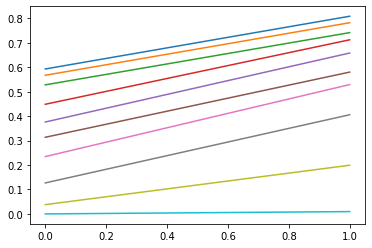

In [73]:
plt.plot(PvsRbox[3:5])

In [82]:
boxsum = np.zeros((10,))
for j in range(80):
    boxsum = boxsum + PvsRbox[j]/80.0

In [83]:
boxsum

array([0.49399848, 0.47109325, 0.44333414, 0.40908616, 0.36776282,
       0.31463857, 0.24283732, 0.16064792, 0.06755672, 0.0076687 ])